## Imports, set seeds, and etc.

### Import necessary libraries

In [1]:
import os
import sys
import glob
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython.display import display, HTML
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, History, TensorBoard

### Define base path, and import necessary functions from .py files

In [2]:
BASE_PATH = r'./'

import load_normalize_data, plots, models

### Set seeds

In [3]:
def set_seeds(seed=2):
    tf.keras.utils.set_random_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    
    
set_seeds()

### Display setting

In [4]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
sns.set(style='whitegrid', rc={'figure.figsize':(13, 8), 'axes.spines.right': False,
                               'axes.spines.top': False, 'axes.grid': False})
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 55)
pd.set_option('display.precision', 3)
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3)

### Define address and name of all trials

In [5]:
all_trials_address = [BASE_PATH + 'Data/Article/Free Breathing/Free_T{}.mat'.format(i) for i in range(1, 52)]
all_trials_name = [i.split('/')[-1].split('.')[0] for i in all_trials_address]

assert len(all_trials_address)==51

## Data

### View data

In [6]:
hrv = pd.read_csv(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented' + '/HRV.csv')
hrv = hrv.set_index('Trial Name')
hrv.index.name = None
display(hrv.transpose())

,Free_T1_P1,Free_T1_P2,Free_T2_P1,...,Free_T49_P1,Free_T50_P1,Free_T51_P1
Mean_NN,1103.738,1077.727,979.500,...,690.756,696.529,689.942
Mean_HR,54.448,55.858,62.190,...,87.118,86.375,87.191
STD_HR,2.186,3.287,7.917,...,4.734,4.468,4.438
SDSD,43.343,54.279,68.476,...,23.911,22.360,24.111
SDNN,44.330,61.609,117.587,...,37.774,36.751,35.697
RMSSD,43.143,54.030,68.188,...,23.842,22.294,24.049
NN50,18.000,27.000,54.000,...,4.000,4.000,6.000
pNN50,16.981,24.771,45.378,...,2.339,2.367,3.509
Power_VLF,249.667,924.999,6969.480,...,146.889,131.300,84.834
Power_LF,491.490,893.280,795.320,...,1095.442,1006.261,409.940


In [7]:
display(hrv.describe().transpose())

,count,mean,std,...,50%,75%,max
Mean_NN,52.0,887.715,143.517,...,844.429,1048.095,1109.626
Mean_HR,52.0,69.765,11.379,...,71.411,78.864,92.247
STD_HR,52.0,4.757,2.270,...,3.978,6.548,9.715
SDSD,52.0,56.291,38.062,...,44.872,59.609,207.752
SDNN,52.0,61.092,30.095,...,53.150,68.955,148.632
RMSSD,52.0,56.080,37.913,...,44.703,59.373,206.899
NN50,52.0,29.308,20.286,...,25.000,37.500,75.000
pNN50,52.0,22.119,14.814,...,18.649,30.479,59.016
Power_VLF,52.0,1161.216,1773.843,...,583.552,1328.034,9432.265
Power_LF,52.0,919.134,926.091,...,591.591,1041.946,4790.680


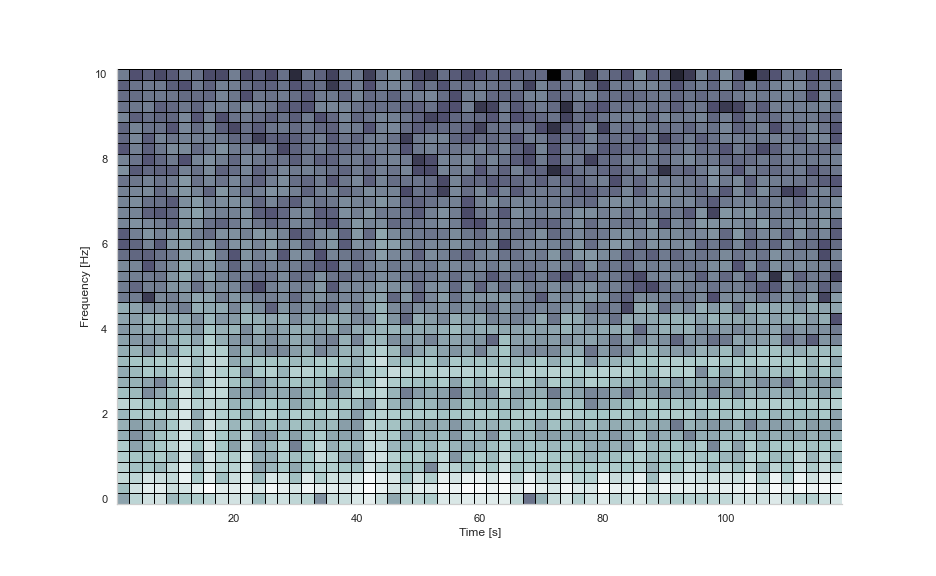

In [8]:
motions_spectogram_tx_p1 = np.load(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented' + '/Free_T' + str(5) + '_P1' + '.npy')
fxx = np.load(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented' + '/fxx.npy')
txx = np.load(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented' + '/txx.npy')

plt.pcolormesh(txx, fxx, 10*np.log10(motions_spectogram_tx_p1[:,:,0]), edgecolors='black', cmap ='bone', shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.show()

## Deep Learning

### Define callbacks

In [9]:
def callbacks(model_name, iteration_number, Y_name, mode=0, verbose=True):
  
    def schedule(epoch, learning_rate):
        if epoch>=200 and epoch%100==0:
            learning_rate *= 0.5
        return learning_rate

    learning_rate_scheduler = LearningRateScheduler(schedule, verbose=verbose)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=verbose, mode='auto')
    model_checkpoint1 = ModelCheckpoint(BASE_PATH + 'Weights/' + model_name + '/' + Y_name + '/fold' + str(iteration_number) + '.h5',
                                        monitor='val_loss', verbose=verbose, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
    model_checkpoint2 = ModelCheckpoint(BASE_PATH + 'Weights/' + model_name + '/' + Y_name + '/fold' + str(iteration_number) + '.h5',
                                        monitor='val_mape', verbose=verbose, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

    if mode==0:
        return None
    elif mode==1:
        return [learning_rate_scheduler]
    elif mode==2:
        return [early_stopping]
    elif mode==3:
        return [model_checkpoint1]
    elif mode==4:
        return [model_checkpoint2]
    else:
        return [learning_rate_scheduler, early_stopping]

### Evalute with metrics

In [10]:
def calculate_metrics_1fold(model, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    [train_loss, train_rmse, train_mae, train_mape] = model.evaluate(X_train, Y_train, verbose=0)
    [val_loss, val_rmse, val_mae, val_mape] = model.evaluate(X_val, Y_val, verbose=0)
    [test_loss, test_rmse, test_mae, test_mape] = model.evaluate(X_test, Y_test, verbose=0)
    
    metrics = {}
    metrics['train_loss'] = train_loss
    metrics['train_rmse'] = train_rmse
    metrics['train_mae'] = train_mae
    metrics['train_mape'] = train_mape
    metrics['val_loss'] = val_loss
    metrics['val_rmse'] = val_rmse
    metrics['val_mae'] = val_mae
    metrics['val_mape'] = val_mape
    metrics['test_loss'] = test_loss
    metrics['test_rmse'] = test_rmse
    metrics['test_mae'] = test_mae
    metrics['test_mape'] = test_mape
    
    return metrics

In [11]:
def calculate_metrics_kfold(Y_real_and_Y_predict):
    Y_real = Y_real_and_Y_predict[:, 0]
    Y_predict = Y_real_and_Y_predict[:, 1]

    metrics = {}
    metrics['mse'] = mean_squared_error(Y_real, Y_predict)
    metrics['rmse'] = math.sqrt(mean_squared_error(Y_real, Y_predict))
    metrics['mae'] = mean_absolute_error(Y_real, Y_predict)
    metrics['mape'] = mean_absolute_percentage_error(Y_real, Y_predict) * 100

    return metrics

### Create folds ***(10 folds)***

In [12]:
def create_folds(all_trials_name):
    np.random.shuffle(all_trials_name)
    folds = np.array_split(all_trials_name, 10)
    return folds

folds = create_folds(all_trials_name)
display(pd.DataFrame(folds, columns=['Trial Name {}'.format(i) for i in range(6)], index=['Fold {}'.format(i) for i in range(0, 10)]))

# folds[3] = np.delete(folds[3], 4) # for Power_LF
# folds[5] = np.delete(folds[5], 1) # for Power_HF
# folds[4] = np.delete(folds[4], 0) # for NN50

,Trial Name 0,Trial Name 1,Trial Name 2,Trial Name 3,Trial Name 4,Trial Name 5
Fold 0,Free_T43,Free_T14,Free_T50,Free_T25,Free_T1,Free_T31
Fold 1,Free_T10,Free_T24,Free_T18,Free_T48,Free_T29,None
Fold 2,Free_T26,Free_T36,Free_T47,Free_T45,Free_T13,None
Fold 3,Free_T38,Free_T17,Free_T3,Free_T30,Free_T28,None
Fold 4,Free_T15,Free_T33,Free_T6,Free_T34,Free_T2,None
Fold 5,Free_T37,Free_T7,Free_T42,Free_T20,Free_T39,None
Fold 6,Free_T11,Free_T5,Free_T4,Free_T21,Free_T27,None
Fold 7,Free_T40,Free_T22,Free_T49,Free_T32,Free_T35,None
Fold 8,Free_T8,Free_T51,Free_T12,Free_T19,Free_T44,None
Fold 9,Free_T23,Free_T9,Free_T46,Free_T16,Free_T41,None


### Train model

In [13]:
def kfold_train(folds, Y_name, model_name, learning_rate, epoch, batch_size, mode, verbose=False):
    
    history = list()
    Y_real_and_Y_predict_val = list()
    Y_real_and_Y_predict_test = list()
    
    index = 0
    train_start_index = 0
    val_start_index = len(folds) - 2
    test_start_index = len(folds) - 1
    
    if len(glob.glob(BASE_PATH + 'Weights'))==0:
        os.mkdir(BASE_PATH + 'Weights')

    if len(glob.glob(BASE_PATH + 'Weights/' + model_name))==0:
        os.mkdir(BASE_PATH + 'Weights/' + model_name)
        
    if len(glob.glob(BASE_PATH + 'Weights/' + model_name + '/' + Y_name))==0:
        os.mkdir(BASE_PATH + 'Weights/' + model_name + '/' + Y_name)
        
    if len(glob.glob(BASE_PATH + 'Results'))==0:
        os.mkdir(BASE_PATH + 'Results')

    if len(glob.glob(BASE_PATH + 'Results/' + model_name))==0:
        os.mkdir(BASE_PATH + 'Results/' + model_name)
        
    if len(glob.glob(BASE_PATH + 'Results/' + model_name + '/' + Y_name))==0:
        os.mkdir(BASE_PATH + 'Results/' + model_name + '/' + Y_name)

    for i in range(10):
        train_names = list()
        val_names = list()
        test_names = list()
        
        for j in range(8):
            if((train_start_index + j) >= 10):
                index = train_start_index + j - 10
            else:
                index = train_start_index + j
            for path in folds[index]:
                train_names.append(path)
            
        if(val_start_index >= 10):
            index = val_start_index - 10
        else:
            index = val_start_index
        for path in folds[index]:
            val_names.append(path)
        
        if(test_start_index >= 10):
            index = test_start_index - 10
        else:
            index = test_start_index
        for path in folds[index]:
            test_names.append(path)
        
        X_train, Y_train = load_normalize_data.load_data(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented', train_names, Y_name)
        X_val, Y_val = load_normalize_data.load_data(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented', val_names, Y_name)
        X_test, Y_test = load_normalize_data.load_data(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented', test_names, Y_name)
            
        X_train, X_val, X_test = load_normalize_data.normalize(X_train, X_val, X_test)

        tf.keras.backend.clear_session()
        model = models.CNN((X_train.shape[1], X_train.shape[2], X_train.shape[3]))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse',
                      metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])  #, clipnorm=.1)
        
        if i==0: 
            model.summary()
        
        print('Training Fold :', i)
        print('X_train shape :', X_train.shape)

        model_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epoch, batch_size=batch_size,
                                  verbose=verbose, shuffle=True, callbacks=callbacks(model_name, i, Y_name, mode=mode, verbose=verbose))

        if mode!=3 and mode!=4:
            model.save_weights(BASE_PATH + 'Weights/' + model_name + '/' + Y_name + '/fold' + str(i) + '.h5')

        model.load_weights(BASE_PATH + 'Weights/' + model_name + '/' + Y_name + '/fold' + str(i) + '.h5')

        plots.plot_history(model_history)

        metrics_1fold = calculate_metrics_1fold(model, X_train, Y_train, X_val, Y_val, X_test, Y_test)
        history.append(metrics_1fold)

        Y_predict_val = model.predict(X_val, verbose=0)
        Y_predict_test = model.predict(X_test, verbose=0)
        
        if Y_name=='NN50':
            Y_predict_val = np.around(Y_predict_val)
            Y_predict_test = np.around(Y_predict_test)
        
        Y_real_and_Y_predict_val.append(np.hstack((Y_val.reshape(-1, 1), Y_predict_val.reshape(-1, 1))))
        Y_real_and_Y_predict_test.append(np.hstack((Y_test.reshape(-1, 1), Y_predict_test.reshape(-1, 1))))

        print('val  :', "{:.3f}".format(mean_absolute_percentage_error(Y_real_and_Y_predict_val[i][:, 0],
                                                                       Y_real_and_Y_predict_val[i][:, 1]) * 100))
        print('test :', "{:.3f}".format(mean_absolute_percentage_error(Y_real_and_Y_predict_test[i][:, 0],
                                                                       Y_real_and_Y_predict_test[i][:, 1]) * 100), '\n')

        train_start_index += 1
        val_start_index += 1
        test_start_index += 1

    metrics_all_val = calculate_metrics_kfold(np.vstack(Y_real_and_Y_predict_val))      
    metrics_all_test = calculate_metrics_kfold(np.vstack(Y_real_and_Y_predict_test))
    print('\nPlots for all validation sets')
    plots.plot_prediction(np.vstack(Y_real_and_Y_predict_val)[:, 0], np.vstack(Y_real_and_Y_predict_val)[:, 1])
    print('\nPlots for all test sets')
    plots.plot_prediction(np.vstack(Y_real_and_Y_predict_val)[:, 0], np.vstack(Y_real_and_Y_predict_val)[:, 1])

    resualts_kfold = pd.DataFrame()
    resualts_kfold['val'] = pd.DataFrame.from_dict(metrics_all_val, orient='index')
    resualts_kfold['test'] = pd.DataFrame.from_dict(metrics_all_test, orient='index')
    resualts_kfold.to_csv(BASE_PATH + 'Results/' + model_name + '/' + Y_name + '/kfold_resualts.csv', index=True, index_label='')

    resualts_each_fold = pd.DataFrame(history)
    resualts_each_fold.to_csv(BASE_PATH + 'Results/' + model_name + '/' + Y_name + '/resualts_each_fold.csv', index=True, index_label='')

    return metrics_all_val, metrics_all_test

In [14]:
# metrics_all_val, metrics_all_test = kfold_train(folds, 'Mean_NN', 'Draft',
#                                                 learning_rate=2e-4, epoch=10, batch_size=8, mode=0, verbose=False)

In [15]:
if 'metrics_all_val' in locals():
    results_val = pd.DataFrame.from_dict(metrics_all_val, orient='index', columns=['Validation']).transpose()
    results_test = pd.DataFrame.from_dict(metrics_all_test, orient='index', columns=['Test']).transpose()
    results = pd.concat([results_val, results_test])
    display(results)

### Evalute from saved weights

In [16]:
def kfold_evalute(folds, Y_name, model_name, show=False):
    
    dfs_value = list()
    dfs_mape = list()
    Y_real_and_Y_predict_val = list()
    Y_real_and_Y_predict_test = list()
    
    index = 0
    train_start_index = 0
    val_start_index = len(folds) - 2
    test_start_index = len(folds) - 1
    

    for i in tqdm(range(10)):
        train_names = list()
        val_names = list()
        test_names = list()
        
        for j in range(8):
            if((train_start_index + j) >= 10):
                index = train_start_index + j - 10
            else:
                index = train_start_index + j
            for path in folds[index]:
                train_names.append(path)
            
        if(val_start_index >= 10):
            index = val_start_index - 10
        else:
            index = val_start_index
        for path in folds[index]:
            val_names.append(path)
        
        if(test_start_index >= 10):
            index = test_start_index - 10
        else:
            index = test_start_index
        for path in folds[index]:
            test_names.append(path)

        X_train, Y_train = load_normalize_data.load_data(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented', train_names, Y_name)
        X_val, Y_val = load_normalize_data.load_data(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented', val_names, Y_name)
        X_test, Y_test = load_normalize_data.load_data(BASE_PATH + 'Data/DownSampled_and_HRV/Segmented', test_names, Y_name)
            
        X_train, X_val, X_test = load_normalize_data.normalize(X_train, X_val, X_test)

        tf.keras.backend.clear_session()
        model = models.CNN((X_train.shape[1], X_train.shape[2], X_train.shape[3]))
        model.load_weights(BASE_PATH + 'Weights/' + model_name + '/' + Y_name + '/fold' + str(i) + '.h5')

        if i==0: 
            model.summary()

        Y_predict_val = model.predict(X_val, verbose=0)
        Y_predict_test = model.predict(X_test, verbose=0)
        
        if Y_name=='NN50':
            Y_predict_val = np.around(Y_predict_val)
            Y_predict_test = np.around(Y_predict_test)
        
        Y_real_and_Y_predict_val.append(np.hstack((Y_val.reshape(-1, 1), Y_predict_val.reshape(-1, 1))))
        Y_real_and_Y_predict_test.append(np.hstack((Y_test.reshape(-1, 1), Y_predict_test.reshape(-1, 1))))

        dfs_value.append(pd.concat([pd.DataFrame([i for x in range(max([Y_real_and_Y_predict_val[i].shape[0],
                                                                        Y_real_and_Y_predict_test[i].shape[0]]))], columns=['fold number']), 
                                    pd.DataFrame(Y_real_and_Y_predict_val[i]), pd.DataFrame(Y_real_and_Y_predict_test[i])], axis=1))
        
        dfs_mape.append(pd.DataFrame([mean_absolute_percentage_error(Y_real_and_Y_predict_val[i][:, 0],
                                                                     Y_real_and_Y_predict_val[i][:, 1]) * 100, 
                         mean_absolute_percentage_error(Y_real_and_Y_predict_test[i][:, 0],
                                                        Y_real_and_Y_predict_test[i][:, 1]) * 100]).transpose())

        train_start_index += 1
        val_start_index += 1
        test_start_index += 1
    
    print('\nMape of validation and test set for each fold')
    df_mape = pd.concat(dfs_mape)
    df_mape.columns = pd.MultiIndex.from_tuples([('Mape','Validation'), ('Mape','Test')], names=['',''])
    df_mape.index = ['Fold {}'.format(x) for x in range(10)]
    display(df_mape)
    
    print('\nReal and predicted value of trials in validation and test set for each fold')
    df_value = pd.concat(dfs_value)
    index_name = pd.MultiIndex.from_tuples(list(zip(*[['Fold {}'.format(x) for x in list(df_value['fold number'])], 
                                                      ['T{}'.format(x) for y in [df_value.loc[df_value['fold number']==x].index
                                                                                 for x in range(10)] for x in y]])), names=['', ''])
    df_value = df_value.drop('fold number', axis=1)
    df_value.columns = pd.MultiIndex.from_tuples([('Validation','Real value'), ('Validation','Predicted value'),
                                                  ('Test','Real value'), ('Test','Predicted value')], names=['', ''])
    df_value = df_value.set_index(index_name)
    display(df_value)
        
    metrics_all_val = calculate_metrics_kfold(np.vstack(Y_real_and_Y_predict_val))      
    metrics_all_test = calculate_metrics_kfold(np.vstack(Y_real_and_Y_predict_test))
    print('\nPlots for all validation sets')
    plots.plot_prediction(np.vstack(Y_real_and_Y_predict_val)[:, 0], np.vstack(Y_real_and_Y_predict_val)[:, 1])
    print('\nPlots for all test sets')
    plots.plot_prediction(np.vstack(Y_real_and_Y_predict_val)[:, 0], np.vstack(Y_real_and_Y_predict_val)[:, 1])
    
    return metrics_all_val, metrics_all_test

  0%|          | 0/10 [00:00<?, ?it/s]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_1 (InputLayer)        [(None, 41, 59, 54)]      0         
                                                                 
 Conv_1 (Conv2D)             (None, 41, 59, 64)        31168     
                                                                 
 Conv_2 (Conv2D)             (None, 41, 59, 64)        36928     
                                                                 
 MaxPooling_1 (MaxPooling2D)  (None, 20, 29, 64)       0         
                                                                 
 Conv_3 (Conv2D)             (None, 20, 29, 128)       73856     
                                                                 
 Conv_4 (Conv2D)             (None, 20, 29, 128)       147584    
                                                                 
 MaxPooling_2 (MaxPooling2D)  (None, 10, 14, 128)      0     

Mape        
       Validation    Test
Fold 0     10.856  19.605
Fold 1     10.111  23.613
Fold 2     20.100  19.906
Fold 3     12.603  15.326
Fold 4     15.594  16.834
Fold 5     28.148  38.747
Fold 6     24.640  13.031
Fold 7      8.795  19.671
Fold 8      9.982  15.619
Fold 9     13.285  13.788


Real and predicted value of trials in validation and test set for each fold


Validation                       Test                
          Real value Predicted value Real value Predicted value
                                                               
Fold 0 T0    146.903         147.249    108.992         145.351
       T1     23.600          27.395     20.245          18.723
       T2     22.700          25.384     39.703          30.243
       T3     27.712          31.231     27.992          27.153
       T4     17.049          14.757     40.418          28.162
Fold 1 T0    108.992         138.808     30.648          41.497
       T1     20.245          20.351     38.381          48.482
       T2     39.703          37.975     75.758          25.924
       T3     27.992          23.460     57.273          60.016
       T4     40.418          39.556     23.188          22.473
       T5        NaN             NaN     41.623          32.347
       T6        NaN             NaN     15.811          17.019
Fold 2 T0     30.648          37.839     20.578          22.381
       T1     38.381          40.717     26.562          21.196
       T2     75.758          29.339     33.689          41.452
       T3     57.273          58.191     62.579          48.229
       T4     23.188          25.775     43.732          32.977
       T5     41.623          26.742        NaN             NaN
       T6     15.811          16.027        NaN             NaN
Fold 3 T0     20.578          26.132     33.457          26.308
       T1     26.562          26.360     58.011          62.815
       T2     33.689          36.186     22.429          26.785
       T3     62.579          53.464     32.811          37.387
       T4     43.732          37.925     36.941          31.911
Fold 4 T0     33.457          24.097     52.115          35.235
       T1     58.011          53.444     19.312          17.447
       T2     22.429          24.683     69.431          54.438
       T3     32.811          33.979     24.501          25.898
       T4     36.941          26.410     28.732          24.473
Fold 5 T0     52.115          34.951     48.420          50.212
       T1     19.312          22.709     30.442          33.346
       T2     69.431          57.885     11.622          22.039
       T3     24.501          37.526     22.626          42.292
       T4     28.732          22.863     30.618          31.830
Fold 6 T0     48.420          38.583    131.612          80.048
       T1     30.442          40.003     34.443          33.151
       T2     11.622          18.788     23.797          24.069
       T3     22.626          22.878     25.649          25.930
       T4     30.618          27.949     35.391          42.464
Fold 7 T0    131.612         117.887     35.698          21.793
       T1     34.443          30.935     28.978          19.042
       T2     23.797          23.260     19.381          23.298
       T3     25.649          30.645     38.580          37.080
       T4     35.391          35.966     69.561          68.853
Fold 8 T0     35.698          33.704     34.195          37.701
       T1     28.978          29.324     53.423          23.399
       T2     19.381          26.087     25.130          26.753
       T3     38.580          37.160     30.449          29.940
       T4     69.561          66.184     16.908          17.501
Fold 9 T0     34.195          36.761    146.903         134.256
       T1     53.423          24.317     23.600          22.262
       T2     25.130          25.760     22.700          21.915
       T3     30.449          30.782     27.712          40.460
       T4     16.908          17.049     17.049          17.935


Plots for all validation sets


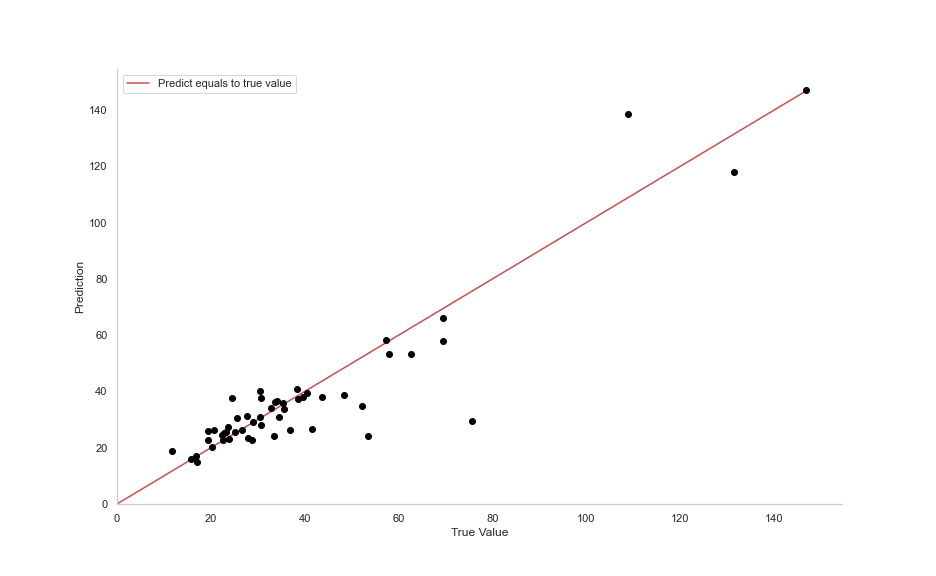

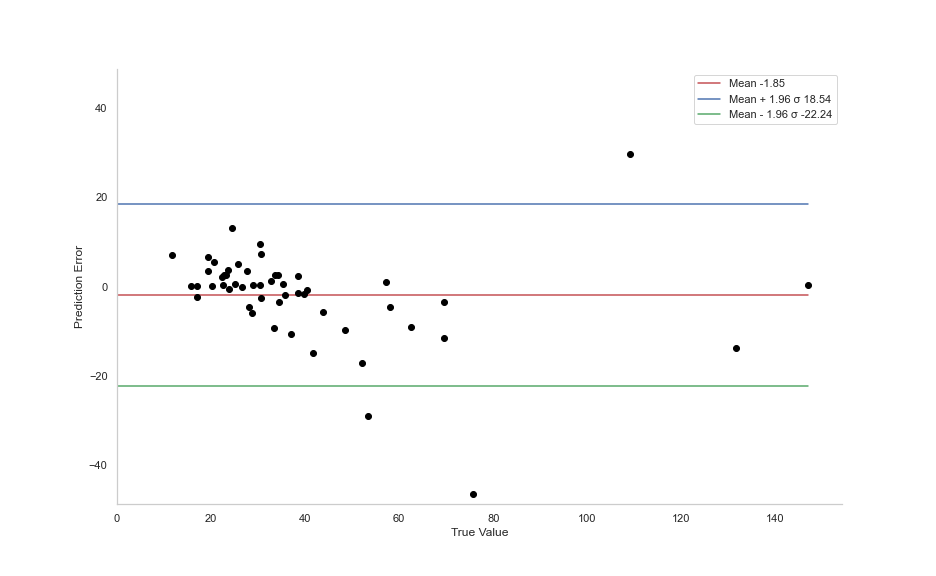

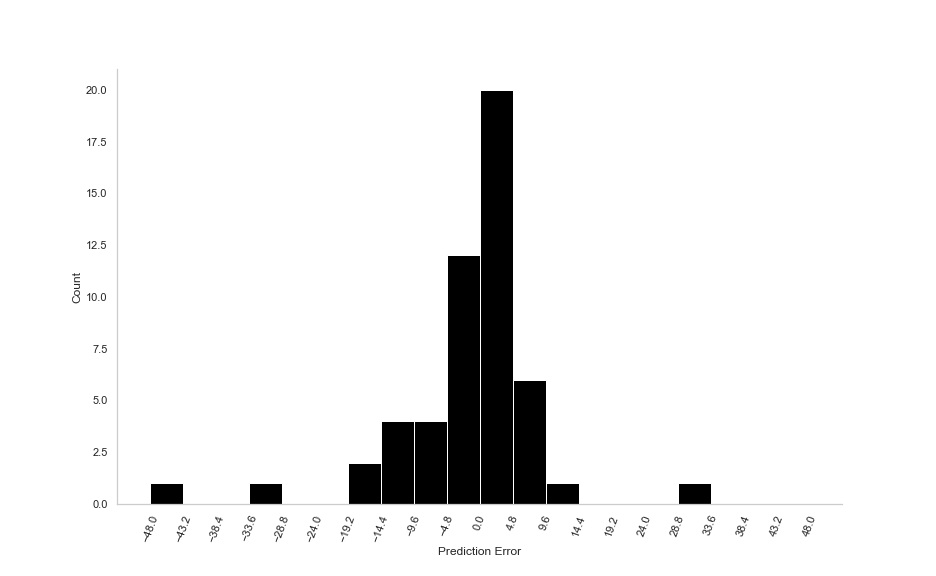


Plots for all test sets


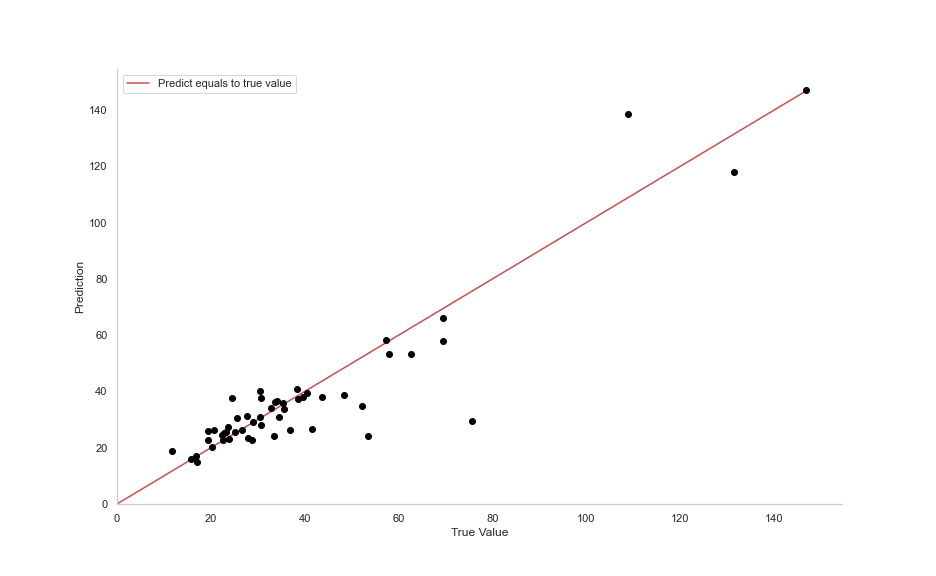

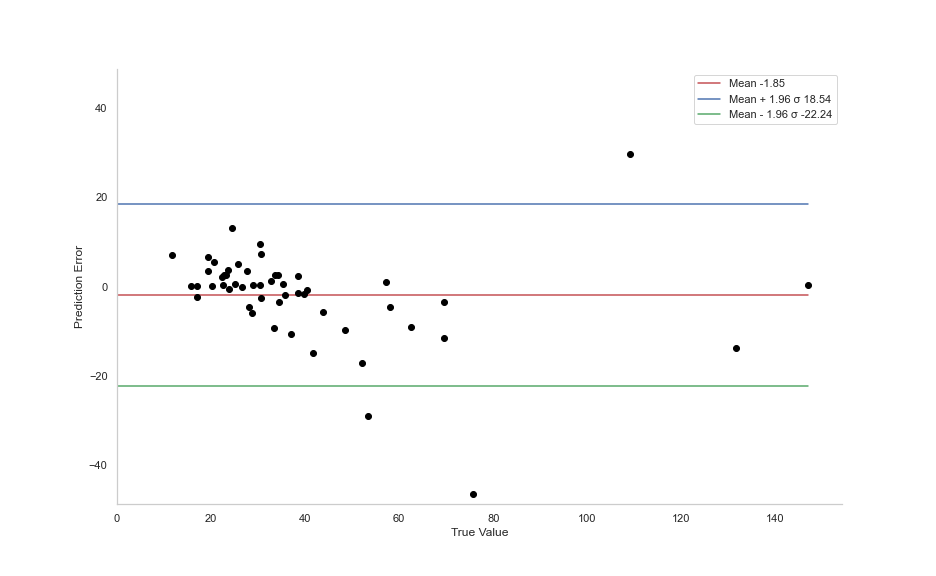

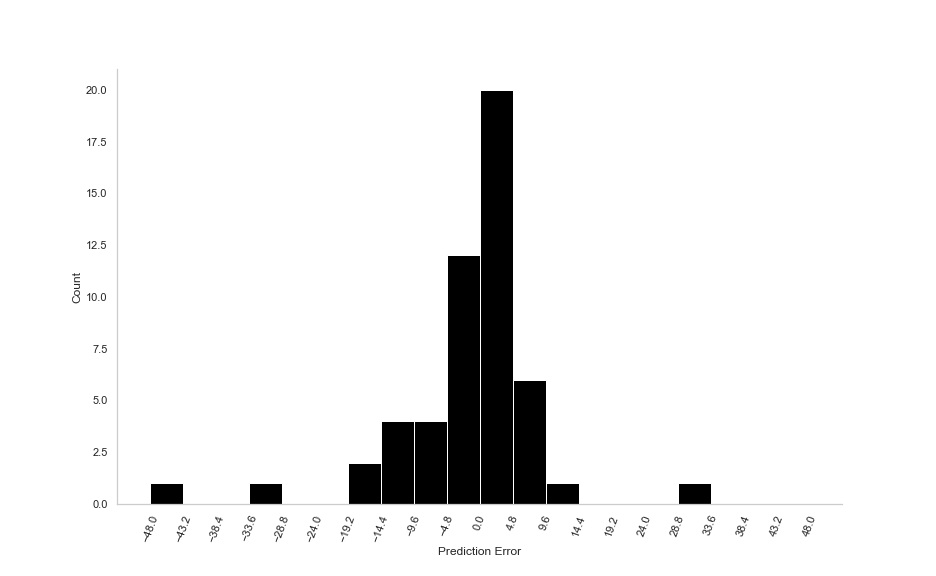

In [17]:
metrics_all_val, metrics_all_test = kfold_evalute(folds, 'SD1', 'BEST_MODEL')

In [18]:
results_val = pd.DataFrame.from_dict(metrics_all_val, orient='index', columns=['Validation']).transpose()
results_test = pd.DataFrame.from_dict(metrics_all_test, orient='index', columns=['Test']).transpose()
results = pd.concat([results_val, results_test])
display(results)

,mse,rmse,mae,mape
Validation,111.665,10.567,6.264,15.592
Test,196.573,14.020,8.492,19.768
